In [1]:
from fastai.basics import *
from itertools import accumulate

In [2]:
%load_ext autoreload
%autoreload 2

https://arxiv.org/abs/2204.00227

### Background

First, a bit of review. Each $x_t$ is dependent on some $x_{t-1}$ in a Markov chain defined below. This we can also define in terms of $a_t$ and $x_0$, so that we can calculate the amount of noise at each step without the calculation being Markovian(or dependent on the previous step). This essentially gives us a formula that is the original image $x_0$ plus some noise $\epsilon$

$$ 
q(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\textbf{I}) \\
\epsilon \sim \mathcal{N}(0,\textbf{I}) \\
a_t := \prod_{s=1}^t{1-\beta_s} \\
x_t = \sqrt{\alpha_t}x_0+\sqrt{1-\alpha_t}\epsilon
$$

Both $\alpha_t$ and $\beta_t$ are of interest to us, so we define the code here. We have 1000 values, one value for each time step $t$.

In [15]:
def at(Bt): return torch.cumprod(1-Bt,-1)
Bt=torch.linspace(1e-4,0.02,1000) #schedule used in DDPM paper
at(Bt).shape

torch.Size([1000])

Signal-to-noise ratio is very important for this paper. We if we put the below two formulas close together the relationship should be clear, remembers that $x_0$ is the original image, and $\epsilon$ is our noise. 

$$ 
x_t = \sqrt{\alpha_t}x_0+\sqrt{1-\alpha_t}\epsilon \\
SNR(t) = \frac{\alpha_t}{1-\alpha_t}$$

In [ ]:
def snr(at): return at/(1-at)

Another noise schedule that is investigated is the cosine noise schedule, we define the code for it below. 

In [ ]:
s=0.008 #from Improved Denoising Diffusion Probabilistic Models
def cos_sched(at): 
    at = torch.linspace(0,1,at.shape[0])
    return torch.cos((at+s)/(1+s)*torch.pi/2)**2

We can now take a look at the noise schedule per diffusion step $t$. Remeber low $\alpha_t$ means more noise $\epsilon$. 

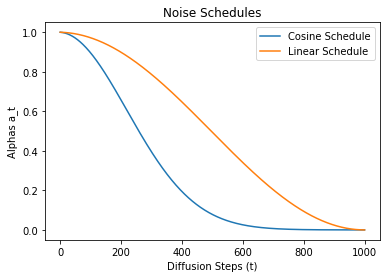

In [4]:
plt.plot(at(Bt))
plt.plot(cos_sched(Bt))
plt.ylabel('Alphas a_t')
plt.xlabel('Diffusion Steps (t)')
plt.title('Noise Schedules')
plt.legend(['Cosine Schedule','Linear Schedule'])

Now we can graph the signal to noise ratio for both the cosine and linear schedules. 

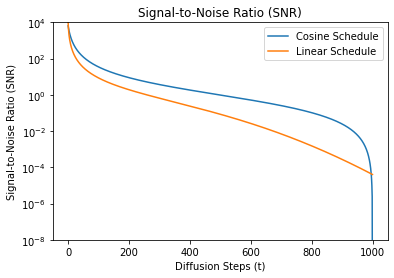

In [5]:
plt.yscale('log')
plt.ylim(top=1e4,bottom=1e-8)
plt.plot(snr(cos_sched(Bt)))
plt.plot(snr(at(Bt)))
plt.ylabel('Signal-to-Noise Ratio (SNR)')
plt.xlabel('Diffusion Steps (t)')
plt.title('Signal-to-Noise Ratio (SNR)')
plt.legend(['Cosine Schedule','Linear Schedule'])

Notice that we get very similar results to the paper as seen below. 

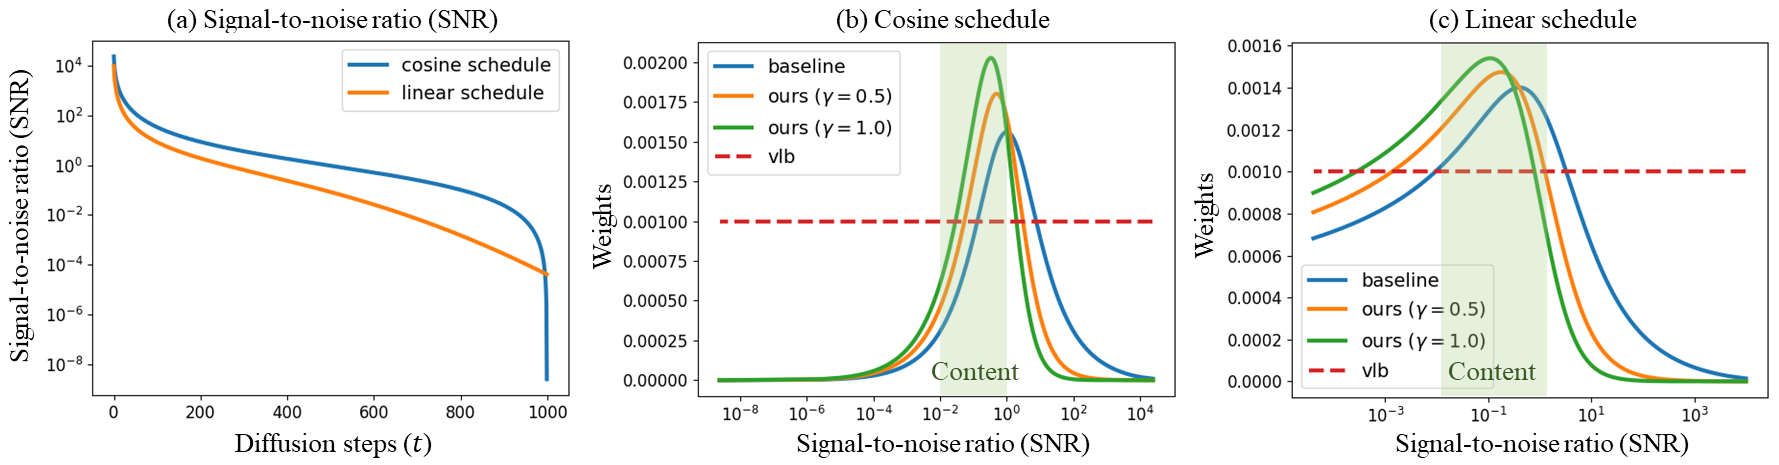

Okay, now we need to determine the weights above. This is the goal of the paper. First we look at the first contribution, a way to calculate the weights in terms of the signal-to-weight ratio, which is a continuous version of the weighting scheme introduced in the DDPM paper. The derivation of this is in the paper's appendix. 

In [6]:
def Ho_weights(Bt,at):
    return (1-Bt)*(1-at)/Bt
def continuous_weights(at):
    weights = -snr(at[1:])/(snr(at[1:])-snr(at[:-1]))
    return torch.cat((weights[0:1],weights)) #we just make a copy of the first to get same shape

We can now compare the unnormalized weights of the continuous weight schedule and the one in the DDPM paper. They are fairly close. 

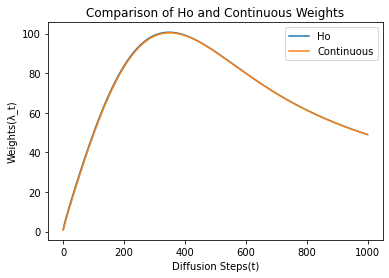

In [7]:
plt.plot(Ho_weights(Bt,at(Bt)))
plt.plot(continuous_weights(at(Bt)))
plt.ylabel('Weights(λ_t)')
plt.xlabel('Diffusion Steps(t)')
plt.title('Comparison of Ho and Continuous Weights')
plt.legend(['Ho','Continuous'])

Next we can look at the prioritized weight schedule. The main contribution of the paper. $\lambda_t$ is our continuous weights from above, k is a constant set to $1$. $\gamma$ is a hyperparameter that we can control, but it doesn't work so well at over 2, because "We empirically observed that γ over 2 suffers
noise artifacts in the sample because it assigns almost zero
weight to the clean-up stage" (quoting paper). 

$$ \lambda_t^\prime = \frac{\lambda_t}{(k+SNR(t))^\gamma} $$

And, here is it in code. $\gamma=0$ essentially turns the prioritized weighting mechanism off, and gives us the same result as the weighting mechanism in the DDPM paper. 

In [16]:
k=1. #set for nice math reasons
def prioritized_weights(l,t,g=0.):
    return l/(k + snr(t))**g

Here we go ahead and generate weights based on a **linear** noise schedule for different values of $\gamma$. Notice how it is similar to the results from the paper. 

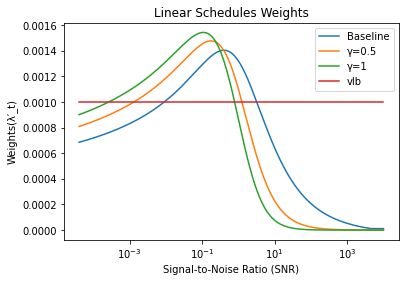

In [9]:
plt.xscale('log')
plt.plot(snr(at(Bt)),F.normalize(continuous_weights(at(Bt)),p=1.,dim=0))
plt.plot(snr(at(Bt)),F.normalize(prioritized_weights(continuous_weights(at(Bt)),at(Bt),g=0.5),p=1.,dim=0))
plt.plot(snr(at(Bt)),F.normalize(prioritized_weights(continuous_weights(at(Bt)),at(Bt),g=1.),p=1.,dim=0))
plt.plot(snr(at(Bt)),torch.full_like(Bt,0.001))
plt.ylabel('Weights(λ′_t)')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.title('Linear Schedules Weights')
plt.legend(['Baseline','γ=0.5','γ=1','vlb'])

Here we go ahead and generate weights based on a **cosine** noise schedule for different values of $\gamma$. Notice how it is similar to the results from the paper. 

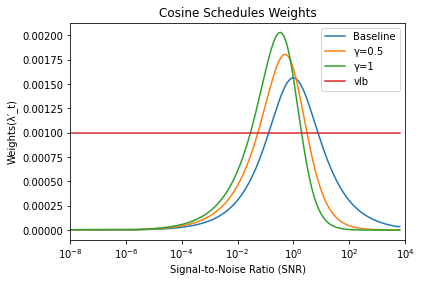

In [10]:
plt.xscale('log')
plt.xlim(left=1e-8,right=1e4)
plt.plot(snr(cos_sched(Bt)),F.normalize(continuous_weights(cos_sched(Bt)),p=1.,dim=0))
plt.plot(snr(cos_sched(Bt)),F.normalize(prioritized_weights(continuous_weights(cos_sched(Bt)),cos_sched(Bt),g=0.5),p=1.,dim=0))
plt.plot(snr(cos_sched(Bt)),F.normalize(prioritized_weights(continuous_weights(cos_sched(Bt)),cos_sched(Bt),g=1.),p=1.,dim=0))
plt.plot(snr(cos_sched(Bt)),torch.full_like(Bt,0.001))
plt.ylabel('Weights(λ′_t)')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.title('Cosine Schedules Weights')
plt.legend(['Baseline','γ=0.5','γ=1','vlb'])

Below you can see various results where the models performed better. Note, on the right, the this paper's model is named P2. For the middle table the schedule makes the most difference when a model is missing attention, suggesting the weighting introduced helps with global features. For the images, notice that the samples generated have better clobal features, though both are going well at smaller details. The authors believe this is because the weights help the model focus more on global features. 

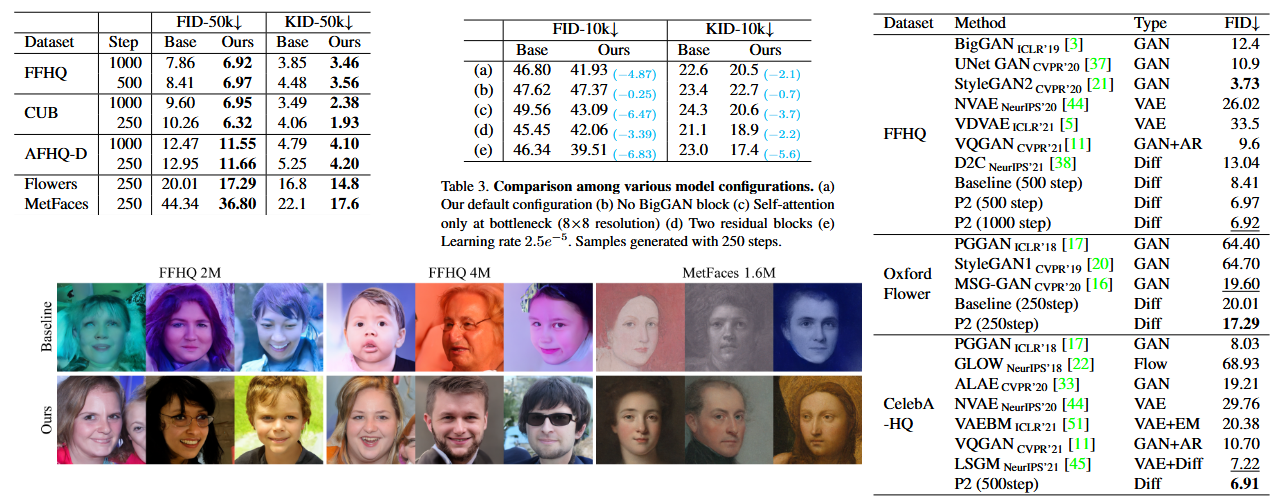